In [1]:
import torch
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Training will run on CPU.")

GPU: NVIDIA GeForce RTX 3050 Laptop GPU is available.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Create a tensor on the CPU
tensor = torch.randn((64,100,1))
#Move the tensor to the GPU
tensor = tensor.to('cuda')

In [4]:
!pip install pandas==1.5.3
import pandas_datareader as pdr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import math
from sklearn.metrics import mean_squared_error

In [5]:
key = 'f99246e0a3e4ce0ccbc6728300dd4160c29c7ccc'

In [6]:
df = pdr.get_data_tiingo('WMT', api_key=key)

C:\Users\Siddharth Gupta\AppData\Local\Temp\ipykernel_94780\4276282949.py:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  df = pdr.get_data_tiingo('WMT', api_key=key)


In [7]:
df.to_csv('WMT.csv')

In [8]:
df = pd.read_csv('WMT.csv')

In [9]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,WMT,2019-09-24 00:00:00+00:00,118.40,119.86,118.01,118.25,7707774,36.531004,36.981470,36.410674,36.484723,23123322,0.0,1.0
1,WMT,2019-09-25 00:00:00+00:00,118.47,118.72,117.81,118.47,4629518,36.552601,36.629736,36.348966,36.552601,13888554,0.0,1.0
2,WMT,2019-09-26 00:00:00+00:00,118.30,119.55,118.19,118.80,3991199,36.500150,36.885823,36.466211,36.654419,11973597,0.0,1.0
3,WMT,2019-09-27 00:00:00+00:00,118.45,119.23,117.75,119.21,3434742,36.546431,36.787091,36.330453,36.780920,10304226,0.0,1.0
4,WMT,2019-09-30 00:00:00+00:00,118.68,119.44,118.56,118.67,3603882,36.617395,36.851884,36.580370,36.614309,10811646,0.0,1.0


In [10]:
df.tail()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
1252,WMT,2024-09-16 00:00:00+00:00,80.56,81.02,80.14,80.84,15346367,80.56,81.02,80.14,80.84,15346367,0.0,1.0
1253,WMT,2024-09-17 00:00:00+00:00,78.60,80.26,78.26,79.76,21065938,78.60,80.26,78.26,79.76,21065938,0.0,1.0
1254,WMT,2024-09-18 00:00:00+00:00,79.03,79.41,78.28,78.64,15684878,79.03,79.41,78.28,78.64,15684878,0.0,1.0
1255,WMT,2024-09-19 00:00:00+00:00,78.04,79.09,77.49,79.05,21525685,78.04,79.09,77.49,79.05,21525685,0.0,1.0
1256,WMT,2024-09-20 00:00:00+00:00,79.06,79.61,78.11,78.23,39534251,79.06,79.61,78.11,78.23,39534251,0.0,1.0


In [11]:
df1 = df.reset_index()['close']

In [12]:
df1

0       118.40
1       118.47
2       118.30
3       118.45
4       118.68
         ...  
1252     80.56
1253     78.60
1254     79.03
1255     78.04
1256     79.06
Name: close, Length: 1257, dtype: float64

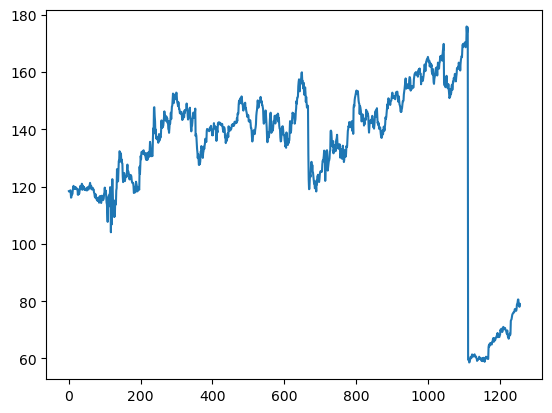

In [13]:
plt.plot(df1)

In [14]:
## MinMax Scaler to Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [15]:
df1

array([[0.50993603],
       [0.51053305],
       [0.50908316],
       ...,
       [0.17415778],
       [0.16571429],
       [0.17441365]])

In [16]:
## Splitting the dataset into train and test split
training_size = int(len(df1)*0.65)
test_size = len(df1) - training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1] 

In [17]:
train_data.shape

(817, 1)

In [18]:
test_data.shape

(440, 1)

In [19]:
## Converting an array of values into a dataset matrix
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range (len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [20]:
## reshape into X=t, t+1, t+2, t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [21]:
print(X_train.shape), print(y_train.shape)

(716, 100)
(716,)


(None, None)

In [22]:
## Reshaping input to be [samples, time_step, features] required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [23]:
## Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

C:\Users\Siddharth Gupta\anaconda3\envs\gpu_env\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [24]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 100, 50)             │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs =100, batch_size = 64, verbose=1)

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 0.2767 - val_loss: 0.0369
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0152 - val_loss: 0.0449
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0083 - val_loss: 0.0424
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0047 - val_loss: 0.0419
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0032 - val_loss: 0.0397
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0029 - val_loss: 0.0389
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0027 - val_loss: 0.0380
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0025 - val_loss: 0.0367
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0026 - val_loss: 0.0355
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0023 - val_loss: 0.0343
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0025 - val_loss: 0.0332
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/ste

In [26]:
## Prediction & Performance Matrix
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [27]:
## Transforming scaled data to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [28]:
## Calculate RMSE performance matrix for train data
math.sqrt(mean_squared_error(y_train, train_predict))

138.20624521102297

In [29]:
## Calculate RMSE performance matrix for test data
math.sqrt(mean_squared_error(y_test, test_predict))

127.77960368103415

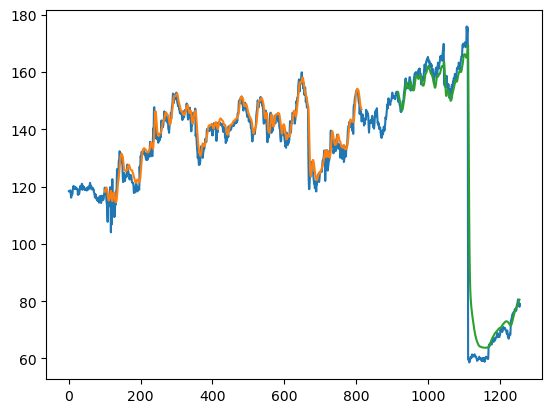

In [33]:
## Plotting
## Shifting train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back,:] = train_predict

## Shifting test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] =np.nan
testPredictPlot[len(train_predict) + (look_back*2)+1: len(df1)-1,:] = test_predict

## Plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# As we can see in the above graph, our model predicted the test data very well